## import

In [2]:

import torch
print(torch.__version__)
import torch
print(torch.cuda.memory_allocated())
print(torch.cuda.memory_reserved()) #版本2.4.1 出现2541有关的数字代表的是241 

2.4.1+cu121
0
0


In [3]:
import torch
print(torch.cuda.is_available())
print(torch.version.cuda)


True
12.1


In [4]:
from torch_geometric.data import Data
from torch_geometric.data import DataLoader
from torch_geometric.nn import GATConv
from torch_cluster import knn

/public/home/wangxin5/miniconda3/envs/torch2541/lib/python3.9/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.27' not found (required by /public/home/wangxin5/miniconda3/envs/torch2541/lib/python3.9/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/public/home/wangxin5/miniconda3/envs/torch2541/lib/python3.9/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.27' not found (required by /public/home/wangxin5/miniconda3/envs/torch2541/lib/python3.9/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "
/public/home/wangxin5/miniconda3/envs/torch2541/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. Se

In [5]:
import os
print("当前工作目录:", os.getcwd())
import sys
print(sys.path)  # 检查是否包含.ipynb所在目录
import sys, os
sys.path.append(os.path.abspath("/public/home/wangxin5/NanoKGAT/NanoKGAT-main/NanoKGAT-main/NanoKGAT/data"))  # 添加当前目录
import sys, os
sys.path.append(os.path.abspath("/public/home/wangxin5/NanoKGAT/NanoKGAT-main/NanoKGAT-main/NanoKGAT"))  # 添加当前目录
import sys
print(sys.path)  # 检查是否包含.ipynb所在目录

当前工作目录: /public/home/wangxin5
['/public/home/wangxin5', '/public/home/wangxin5/miniconda3/envs/torch2541/lib/python39.zip', '/public/home/wangxin5/miniconda3/envs/torch2541/lib/python3.9', '/public/home/wangxin5/miniconda3/envs/torch2541/lib/python3.9/lib-dynload', '', '/public/home/wangxin5/miniconda3/envs/torch2541/lib/python3.9/site-packages', '/public/home/wangxin5/miniconda3/envs/torch2541/lib/python3.9/site-packages/setuptools/_vendor']
['/public/home/wangxin5', '/public/home/wangxin5/miniconda3/envs/torch2541/lib/python39.zip', '/public/home/wangxin5/miniconda3/envs/torch2541/lib/python3.9', '/public/home/wangxin5/miniconda3/envs/torch2541/lib/python3.9/lib-dynload', '', '/public/home/wangxin5/miniconda3/envs/torch2541/lib/python3.9/site-packages', '/public/home/wangxin5/miniconda3/envs/torch2541/lib/python3.9/site-packages/setuptools/_vendor', '/public/home/wangxin5/NanoKGAT/NanoKGAT-main/NanoKGAT-main/NanoKGAT/data', '/public/home/wangxin5/NanoKGAT/NanoKGAT-main/NanoKGAT-main/

In [6]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import classification_report

from antiberty import AntiBERTyRunner


from utils import set_coord
k=8

In [7]:
import pandas as pd
import pickle
# 加载 Parquet 文件

loaded_train = pd.read_parquet("/public/home/wangxin5/NanoKGAT/NanoKGAT-main/NanoKGAT-main/NanoKGAT/data/parquet/train_processed_serialized.parquet")
# 反序列化 'coord' 列
loaded_train['coord'] = loaded_train['coord'].apply(lambda x: pickle.loads(x) if isinstance(x, bytes) else [])
# 加载 Parquet 文件
loaded_val = pd.read_parquet("/public/home/wangxin5/NanoKGAT/NanoKGAT-main/NanoKGAT-main/NanoKGAT/data/parquet/val_processed_serialized.parquet")
# 反序列化 'coord' 列
loaded_val['coord'] = loaded_val['coord'].apply(lambda x: pickle.loads(x) if isinstance(x, bytes) else [])
# 加载 Parquet 文件
loaded_test = pd.read_parquet("/public/home/wangxin5/NanoKGAT/NanoKGAT-main/NanoKGAT-main/NanoKGAT/data/parquet/test_processed_serialized.parquet")
# 反序列化 'coord' 列
loaded_test['coord'] = loaded_test['coord'].apply(lambda x: pickle.loads(x) if isinstance(x, bytes) else [])

In [8]:
loaded_train['coord']

0       [[20.429000854492188, 24.52899932861328, -1.64...
1       [[-50.444000244140625, 69.47200012207031, -28....
2       [[53.52899932861328, 48.84299850463867, 78.050...
3       [[-7.09499979019165, -11.586999893188477, 77.9...
4       [[92.60299682617188, 47.70800018310547, -44.73...
                              ...                        
6880    [[208.1649932861328, 196.677001953125, 282.261...
6881    [[82.03099822998047, 137.75900268554688, 260.2...
6882    [[122.9990005493164, 112.15799713134766, 91.34...
6883    [[201.54600524902344, 153.8459930419922, 215.5...
6884    [[143.36099243164062, 116.68699645996094, 133....
Name: coord, Length: 6885, dtype: object

In [9]:
def make_data(df):
    
    dataset = []
    for seq,label,coord in tqdm(zip(df['sequence'],df['paratope_labels'],df['coord'])):
        seq = [seq]
        size = len(seq[0])

        # 生成 0/1 列表
        binary_list = [1 if lbl == 'P' else 0 for lbl in label]


        # 使用 np.pad 进行填充
        if len(binary_list) < 140:
            pad_length = 140 - len(binary_list)
            binary_list = np.pad(binary_list, (0, pad_length), 'constant', constant_values=0)
        elif len(binary_list) > 140:
            binary_list = binary_list[:140]

        # 转为张量
        label_tensor = torch.tensor(binary_list, dtype=torch.long)

        coord = torch.tensor(coord)
        
        Antiberty = AntiBERTyRunner()
        embeddings = Antiberty.embed(seq)[0][1:-1]

        if size<140:
            pad = torch.zeros((140-size),512).cuda()
            embeddings =torch.cat([embeddings,pad],dim=0)
        elif size > 140:
            embeddings = embeddings[:140].cuda()  # 截断超长部分
        
            
        edge_index = knn(coord,coord,k = k)
        data = Data(x = embeddings, y= label_tensor,edge_index=edge_index,mask=size)
        dataset.append(data)
        
    return dataset


train_dataset = make_data(loaded_train[:])
test_dataset = make_data(loaded_test[:])
val_dataset = make_data(loaded_val[:])


train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False, drop_last=True) 
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, drop_last=True) 



6885it [43:24,  2.64it/s]
496it [03:04,  2.69it/s]
581it [03:36,  2.69it/s]


In [10]:
sample = train_dataset[0]
print(sample)
print("样本目标形状:", sample.x.shape) 

Data(x=[140, 512], edge_index=[2, 1120], y=[140], mask=122)
样本目标形状: torch.Size([140, 512])


In [11]:
for batch in train_loader:
    print(batch)
    print("Batch目标形状:", batch.x.shape) 
    break

DataBatch(x=[1120, 512], edge_index=[2, 8960], y=[1120], mask=[8], batch=[1120], ptr=[9])
Batch目标形状: torch.Size([1120, 512])


In [12]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import BatchNorm1d, Linear, Sequential
from torch_geometric.nn.conv import EGConv,GATConv
from torch.nn import Linear, Dropout,ELU
import torch.nn.functional as F

In [13]:
class NanoKGAT(torch.nn.Module):
    def __init__(self, hidden_channels, num_layers, num_heads, num_bases):
        super().__init__()
        
        aggregators = ['mean','sum','std','max','min',]
        
        self.Conv1D = nn.Sequential(
                nn.Conv1d(hidden_channels,256,5,dilation = 4,padding = 'same'),
                nn.BatchNorm1d(256)
        ) 

        self.Conv1D_2 = nn.Sequential(
                nn.Conv1d(256,256,5,dilation = 4,padding = 'same'),
                nn.BatchNorm1d(256)
        ) 

        self.Conv1D_dilated = nn.Sequential(
                nn.Conv1d(256,512,3,dilation = 4,padding = 'same'),
                nn.BatchNorm1d(512)
        )
        self.dropout = Dropout(0.25)

        hidden_channels = 512
        self.hidden_channels = hidden_channels
        self.convs = torch.nn.ModuleList()
        self.norms = torch.nn.ModuleList()

        self.attention = GATConv(in_channels=512,out_channels=256,heads=2)
        self.attention_batch = nn.BatchNorm1d(512)

        for _ in range(num_layers):
            self.convs.append(
                EGConv(hidden_channels, hidden_channels, aggregators,
                       num_heads, num_bases))
            self.norms.append(BatchNorm1d(hidden_channels))
    
        self.mlp = Sequential(
            Linear(hidden_channels, hidden_channels // 2, bias=False),
            BatchNorm1d(hidden_channels // 2),
            ELU(inplace=True),
            Linear(hidden_channels // 2, hidden_channels // 4, bias=False),
            BatchNorm1d(hidden_channels // 4),
            ELU(inplace=True),
            Linear(hidden_channels // 4, hidden_channels // 8, bias=False),
            BatchNorm1d(hidden_channels // 8),
            ELU(inplace=True),
            Linear(hidden_channels // 8, 1),

        )

    def forward(self, data):
        x, edge_index, batch  = data.x.cuda(), data.edge_index.cuda(), data.batch
        batch_size = 8 #此处修改batch_size
        x = x.view(-1,140,512).permute(0,2,1)
        x1 = F.relu(self.Conv1D(x))
        x1 = F.relu(self.Conv1D_2(x1))
        x1 = F.relu(self.Conv1D_dilated(x1))
        x  = x1 + x
        x = x.permute(0,2,1).reshape(140*batch_size,self.hidden_channels)
    
        for conv, norm in zip(self.convs, self.norms):
            h = conv(x, edge_index)
            h = norm(h)
            h = h.relu_()
            x = x + h
        x1,attention = self.attention(x,edge_index,return_attention_weights=True)
        x = x + self.attention_batch(x1.relu_())
        return F.sigmoid(self.mlp(x))

In [14]:
def train(model, train_loader, val_loader, epochs, device):
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCEWithLogitsLoss()

    train_losses = []
    val_losses = []

    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        for batch in train_loader:
            input, target = batch.x, batch.y
            batch = batch.to(device)
            optimizer.zero_grad()
            output = model(batch)
            batch.y = batch.y.view(-1, 1).float()
            loss = criterion(output, batch.y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)


        # 评估
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                output = model(batch)
                batch.y = batch.y.view(-1, 1).float()

                loss = criterion(output, batch.y)#.float()
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    return train_losses, val_losses

def plot_losses(train_losses, val_losses, filename):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig(filename)
    plt.show()

def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            output = model(batch)
            preds = (output > 0).float()
            correct += (preds == batch.y).sum().item()
            total += batch.y.size(0)
    accuracy = correct / total
    return accuracy


Using device: cuda:0
Epoch 1/20, Train Loss: 0.6968, Val Loss: 0.6846
Epoch 2/20, Train Loss: 0.6831, Val Loss: 0.6817
Epoch 3/20, Train Loss: 0.6813, Val Loss: 0.6806
Epoch 4/20, Train Loss: 0.6801, Val Loss: 0.6793
Epoch 5/20, Train Loss: 0.6790, Val Loss: 0.6787
Epoch 6/20, Train Loss: 0.6778, Val Loss: 0.6774
Epoch 7/20, Train Loss: 0.6772, Val Loss: 0.6771
Epoch 8/20, Train Loss: 0.6767, Val Loss: 0.6768
Epoch 9/20, Train Loss: 0.6759, Val Loss: 0.6758
Epoch 10/20, Train Loss: 0.6752, Val Loss: 0.6763
Epoch 11/20, Train Loss: 0.6748, Val Loss: 0.6746
Epoch 12/20, Train Loss: 0.6741, Val Loss: 0.6747
Epoch 13/20, Train Loss: 0.6738, Val Loss: 0.6741
Epoch 14/20, Train Loss: 0.6734, Val Loss: 0.6742
Epoch 15/20, Train Loss: 0.6733, Val Loss: 0.6736
Epoch 16/20, Train Loss: 0.6728, Val Loss: 0.6735
Epoch 17/20, Train Loss: 0.6726, Val Loss: 0.6727
Epoch 18/20, Train Loss: 0.6722, Val Loss: 0.6726
Epoch 19/20, Train Loss: 0.6719, Val Loss: 0.6723
Epoch 20/20, Train Loss: 0.6717, Val L

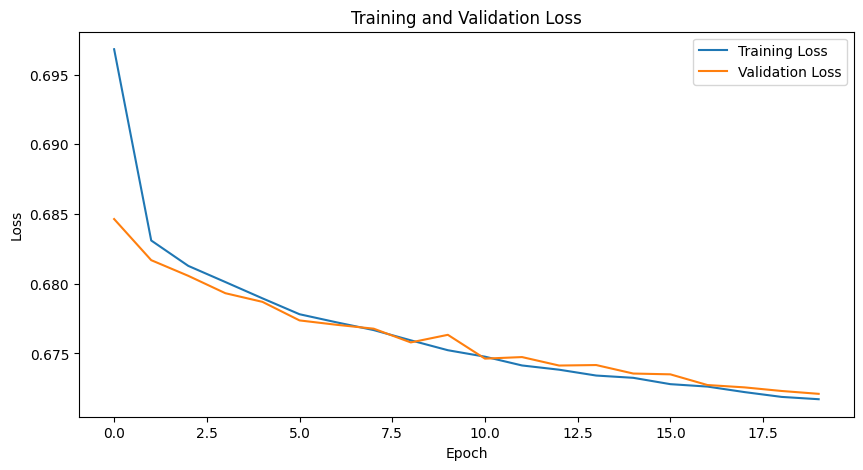

Test Accuracy: 127.7419
模型已保存到 model_weights-epoach20.pth
Test Accuracy: 127.7419
模型已保存到 model_weights-epoach20.pth
Loaded Model Test Accuracy: 127.7419
Epoch 1/100, Train Loss: 0.6715, Val Loss: 0.6719
Epoch 2/100, Train Loss: 0.6713, Val Loss: 0.6719
Epoch 3/100, Train Loss: 0.6714, Val Loss: 0.6718
Epoch 4/100, Train Loss: 0.6710, Val Loss: 0.6717
Epoch 5/100, Train Loss: 0.6708, Val Loss: 0.6716
Epoch 6/100, Train Loss: 0.6707, Val Loss: 0.6715
Epoch 7/100, Train Loss: 0.6704, Val Loss: 0.6707
Epoch 8/100, Train Loss: 0.6703, Val Loss: 0.6710
Epoch 9/100, Train Loss: 0.6701, Val Loss: 0.6703
Epoch 10/100, Train Loss: 0.6702, Val Loss: 0.6706
Epoch 11/100, Train Loss: 0.6698, Val Loss: 0.6702
Epoch 12/100, Train Loss: 0.6695, Val Loss: 0.6705
Epoch 13/100, Train Loss: 0.6696, Val Loss: 0.6703
Epoch 14/100, Train Loss: 0.6694, Val Loss: 0.6697
Epoch 15/100, Train Loss: 0.6692, Val Loss: 0.6700
Epoch 16/100, Train Loss: 0.6693, Val Loss: 0.6702
Epoch 17/100, Train Loss: 0.6690, Val Lo

In [ ]:


if __name__ == '__main__':

    # 设置设备
    device = torch.device('cuda:0')

    print(f"Using device: {device}")  



    # 初始化模型
    hidden_channels = 512
    num_layers = 3
    num_heads = 4
    num_bases = 4
    model = NanoKGAT(hidden_channels, num_layers, num_heads, num_bases)
    model.to(device)



    # 定义要绘制的 Epoch 列表
    epochs_list = [20, 100, 150, 200]
    for e in epochs_list:


        # 训练模型
        train_losses, val_losses = train(model, train_loader, val_loader, epochs=e, device=device)

        # 绘制损失曲线
        plot_losses(train_losses, val_losses, filename=f'loss_{e}.jpg')

        # 评估模型
        test_accuracy = evaluate(model, test_loader, device)
        print(f"Test Accuracy: {test_accuracy:.4f}")

        # 保存模型
        model_path = f'model_weights-epoach{e}.pth'

        torch.save(model.state_dict(), model_path)
        print(f"模型已保存到 {model_path}")

        # 评估、保存和加载模型
        test_accuracy = evaluate(model, test_loader, device)
        print(f"Test Accuracy: {test_accuracy:.4f}")

        model_path = f'model_weights-epoach{e}.pth'
        torch.save(model.state_dict(), model_path)
        print(f"模型已保存到 {model_path}")

        loaded_model = NanoKGAT(hidden_channels, num_layers, num_heads, num_bases)
        loaded_model.load_state_dict(torch.load(model_path))
        loaded_model.to(device)
        loaded_model.eval()

        loaded_accuracy = evaluate(loaded_model, test_loader, device)
        print(f"Loaded Model Test Accuracy: {loaded_accuracy:.4f}")